In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from itertools import cycle
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import TensorboardLogger, global_step_from_engine

Transformacje obrazów: zmiana rozmiaru

In [2]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Zmiana rozmiaru danych wejściowych
    transforms.ToTensor(),  # Konwersja do tensora
])

## Wczytanie datasetu

In [3]:
dataset = datasets.ImageFolder(root='/kaggle/input/umpxray002', transform=transform)

# To see some statistics or details
print(f"Total number of classes: {len(dataset.classes)}")
print(f"Class names: {dataset.classes}")

Total number of classes: 15
Class names: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


## Podział na podzbiory

In [4]:
labels = np.array([label for _, label in dataset.samples])

# Definiujemy podział
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in sss.split(np.zeros(len(labels)), labels):
    train_subset = Subset(dataset, train_index)
    val_subset = Subset(dataset, val_index)

In [5]:
#Dodane,żeby widziec jaka jest reprezentacja liczbowa w każdej z klas w trai_i val_loaders

# Słownik do przechowywania liczby próbek dla każdej klasy
class_counts = {class_name: 0 for class_name in dataset.classes}

# Pętla przez indeksy w train_index
for idx in train_index:  # Używamy train_index bezpośrednio z podziału
    # Uzyskujemy etykietę dla każdego indeksu
    label = labels[idx]
    class_name = dataset.classes[label]
    class_counts[class_name] += 1

# Wydruk liczby próbek dla każdej klasy
for i, (class_name, count) in enumerate(class_counts.items()):
    print(f"Index: {i}, Class: {class_name}, Count: {count}")


Index: 0, Class: Atelectasis, Count: 1591
Index: 1, Class: Cardiomegaly, Count: 537
Index: 2, Class: Consolidation, Count: 249
Index: 3, Class: Edema, Count: 37
Index: 4, Class: Effusion, Count: 1502
Index: 5, Class: Emphysema, Count: 378
Index: 6, Class: Fibrosis, Count: 467
Index: 7, Class: Hernia, Count: 70
Index: 8, Class: Infiltration, Count: 3794
Index: 9, Class: Mass, Count: 984
Index: 10, Class: No Finding, Count: 4000
Index: 11, Class: Nodule, Count: 1386
Index: 12, Class: Pleural_Thickening, Count: 630
Index: 13, Class: Pneumonia, Count: 126
Index: 14, Class: Pneumothorax, Count: 1085


In [6]:
# To samo dla zestawu walidacyjnego
class_counts = {class_name: 0 for class_name in dataset.classes}

for idx in val_index: 
    label = labels[idx]
    class_name = dataset.classes[label]
    class_counts[class_name] += 1
    
for i, (class_name, count) in enumerate(class_counts.items()):
    print(f"Index: {i}, Class: {class_name}, Count: {count}")


Index: 0, Class: Atelectasis, Count: 398
Index: 1, Class: Cardiomegaly, Count: 134
Index: 2, Class: Consolidation, Count: 62
Index: 3, Class: Edema, Count: 9
Index: 4, Class: Effusion, Count: 375
Index: 5, Class: Emphysema, Count: 95
Index: 6, Class: Fibrosis, Count: 116
Index: 7, Class: Hernia, Count: 18
Index: 8, Class: Infiltration, Count: 949
Index: 9, Class: Mass, Count: 246
Index: 10, Class: No Finding, Count: 1000
Index: 11, Class: Nodule, Count: 346
Index: 12, Class: Pleural_Thickening, Count: 158
Index: 13, Class: Pneumonia, Count: 32
Index: 14, Class: Pneumothorax, Count: 271


## Loadery


In [7]:
#Zmiana batch_size na 400

batch_size = 400
# Przygotowanie DataLoaderów
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, drop_last= True)

In [8]:
len(train_loader)
len(val_loader)

10

## Obsługa GPU

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Definicja modelu

In [10]:
class FiveConvTinyCNN(nn.Module):
    def __init__(self):
        super(FiveConvTinyCNN, self).__init__()
        self.feature_extractor = nn.Sequential(      
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),  # Batch normalization
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=48, kernel_size=3, padding=1),
            nn.BatchNorm2d(48),  # Batch normalization
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=48, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),

        
        )
        self.feature_size = self._get_feature_size((3, 100, 100))

        self.classifier = nn.Linear(self.feature_size, len(dataset.classes))
        
    def _get_feature_size(self, input_shape):
    # Forward pass a dummy tensor through the feature extractor to get the output size
        with torch.no_grad():
            dummy_input = torch.randn(1, *input_shape)
            feature_output = self.feature_extractor(dummy_input)
            feature_size = feature_output.view(1, -1).size(1)
        return feature_size
        
    def forward(self, x):
        feature_maps = self.feature_extractor(x)
        print(x.shape)
        feature_maps = feature_maps.view(x.size(0), -1)
        logits = self.classifier(feature_maps)
        
        return logits
    
model = FiveConvTinyCNN().to(device)
    

## Informacje o modelu

In [11]:
model

TinyCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=Tr

In [12]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 216255


## Optymalizator

In [13]:
#Wybór optymalizatora (Adam) oraz wartości learning rate.

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

## Pętla treningowa

In [14]:
trainer = create_supervised_trainer(model, optimizer, criterion, device)


metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion),
}


train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [15]:
unique_labels_array = np.unique(labels)
class_names = list(unique_labels_array)
n_classes = len(class_names)

print("Class names:", class_names)

Class names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [16]:
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

In [17]:

@trainer.on(Events.ITERATION_COMPLETED(every=1))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")
    

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    global metrics 
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics 
    train_losses.append(metrics['loss'])
    train_accuracy.append(metrics['accuracy'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global metrics 
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    val_losses.append(metrics['loss'])
    val_accuracy.append(metrics['accuracy'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

In [18]:
# Definicja funkcji generującej wykresy straty i dokładności
def generate_loss_accuracy_plots(train_losses, val_losses, train_accuracy, val_accuracy):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    
     # Zapisz wykresy do pliku w /kaggle/working
    plt.savefig('/kaggle/working/loss_accuracy_plots.png')
    plt.show()

In [19]:
from ignite.engine import Engine, Events

def predict_function(engine, batch):
    model.eval()
    with torch.no_grad():
        inputs, _ = batch
        inputs = inputs.to(device)
        outputs = model(inputs)
        return outputs

# Tworzenie instancji silnika predykcyjnego
predictor = Engine(predict_function)

# Funkcja do uruchamiania predykcji i zapisywania do CSV
def run_predictions_to_csv(data_loader, file_name,class_names):
    predictions = []
    probabilities = [] #przechowywanie szacowanych probabilities
    labels = []

    # Dekorator do zapisywania wyników po każdej iteracji
    @predictor.on(Events.ITERATION_COMPLETED)
    def store_predictions(engine):
        y_pred = torch.max(engine.state.output, 1)[1]
        probas = F.softmax(engine.state.output, dim=1)  # Użycie softmax
        y = engine.state.batch[1]
        predictions.append(y_pred.cpu().numpy())
        probabilities.append(probas.cpu().numpy().flatten())  # Zapis prawdopodobieństw
        labels.append(y.cpu().numpy())
    
    # Resetowanie list przed uruchomieniem predyktora
        predictions.clear()
        probabilities.clear()  # Resetowanie listy prawdopodobieństw
        labels.clear()

    # Uruchom predykcję
        predictor.run(data_loader)
    
   # Tworzenie DataFrame z przewidywaniami i prawdopodobieństwami
        df_predictions = pd.DataFrame(probabilities, columns=[f'Prob_{cls}' for cls in class_names])
        df_predictions['Predictions'] = predictions
        df_predictions['Labels'] = labels
    
    # Ustawienie poprawnej ścieżki do folderu /kaggle/working/
        output_file = f'/kaggle/working/{file_name}'
    
    # Zapisz wyniki do pliku CSV
        df_predictions.to_csv(output_file, index=False)


# Używanie funkcji
run_predictions_to_csv(val_loader, 'predictions.csv', class_names)

In [20]:
from sklearn.utils.multiclass import unique_labels

def generate_confusion_matrix(model, data_loader, device, class_names,file_suffix):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {file_suffix}')
    plt.savefig(f'/kaggle/working/confusion_matrix_{file_suffix}.png')
    plt.show()
    
def generate_roc_auc(model, data_loader, device, n_classes, class_names, file_suffix):
    # Binarize the labels for One-vs-Rest
    y_test = []
    y_score = []

    model.eval()
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            outputs = model(data)
            y_test.extend(target.cpu().numpy())
            y_score.extend(outputs.cpu().numpy())

    # Use label_binarize for multi-class problem
    y_test = label_binarize(y_test, classes=[*range(n_classes)])
    y_score = np.array(y_score)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(15, 10))  # Możesz zwiększyć rozmiar wykresu, aby poprawić czytelność
    colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightblue', 'orange', 'purple'])
    
    # Tutaj rysujemy krzywe ROC
    for i, color in zip(range(n_classes), colors):
        # Pomiń klasy, dla których nie można obliczyć AUC
#         if np.isnan(roc_auc[i]):
#             continue
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

    # Dodajemy krzywą odniesienia
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Dostosowanie osi wykresu
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    # Etykiety osi
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic to multi-class - {file_suffix}')

    # Umieszczamy legendę poza wykresem
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Przesunięcie legendy poza wykres
    
    plt.savefig(f'/kaggle/working/roc_auc_{file_suffix}.png')

    # Aby zapewnić, że wykres nie będzie ucinał legendy, możesz dostosować layout
#     plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.tight_layout()
    plt.show()

In [21]:
def generate_classification_report(model, data_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Uzyskaj unikalne etykiety z prawdziwych i przewidywanych danych
    present_labels = unique_labels(y_true, y_pred)

    # Filtruj class_names, aby zawierały tylko te klasy, które faktycznie są obecne
    filtered_class_names = [class_names[i] for i in present_labels if i < len(class_names)]

    # Konwertuj filtered_class_names i present_labels na listę ciągów znaków, jeśli jest to konieczne
    present_labels_str = [str(label) for label in present_labels]
    filtered_class_names_str = [str(name) for name in filtered_class_names]

    # Obliczanie precyzji, recall i F1, określając jawnie etykiety
    print(classification_report(y_true, y_pred, labels=present_labels, target_names=filtered_class_names_str, zero_division=0))


In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from itertools import cycle

def plot_precision_recall_curve(model, data_loader, device, n_classes):
    # Kontenery na prawdziwe etykiety i wyniki modelu
    y_true = np.empty((0))
    y_scores = np.empty((0, n_classes))
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_scores = np.vstack((y_scores, F.softmax(outputs, dim=1).cpu().numpy()))
            y_true = np.concatenate((y_true, labels.numpy()))
    
    # Binarizacja etykiet w formacie one-vs-all
    y_true = label_binarize(y_true, classes=[*range(n_classes)])
    
    # Obliczanie Precision-Recall i średniej precyzji dla każdej klasy
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_scores[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_scores[:, i])
    
    # Rysowanie krzywej Precision-Recall
    plt.figure(figsize=(7, 7))
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label='Class {0} (AP = {1:0.2f})'.format(i, average_precision[i]))
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Extension of Precision-Recall curve to multi-class')
    plt.legend(loc="best")
    plt.show()


In [23]:
def generate_documentation(engine, train_loader, val_loader, device, class_names):
    print("Generowanie dokumentacji dla zestawu treningowego:")
    # Wywołanie funkcji generującej wykresy straty i dokładności dla treningu
    generate_loss_accuracy_plots(train_losses, val_losses, train_accuracy, val_accuracy)
    
    # Generowanie macierzy pomyłek dla treningu
    generate_confusion_matrix(model, train_loader, device, class_names, 'train')
    
    # Generowanie krzywej ROC AUC dla treningu
    generate_roc_auc(model, train_loader, device, len(class_names), class_names, 'train')
    
    # Generowanie raportu klasyfikacji dla treningu
    generate_classification_report(model, train_loader, device, class_names)
    
    print("\nGenerowanie dokumentacji dla zestawu walidacyjnego:")
    # Generowanie macierzy pomyłek dla walidacji
    generate_confusion_matrix(model, val_loader, device, class_names, 'val')
    
    # Generowanie krzywej ROC AUC dla walidacji
    generate_roc_auc(model, val_loader, device, len(class_names), class_names, 'val')
    
    # Generowanie raportu klasyfikacji dla walidacji
    generate_classification_report(model, val_loader, device, class_names)
    
    # Generowanie krzywej Precision-Recall dla zestawu walidacyjnego
    print("Generowanie krzywej Precision-Recall dla zestawu walidacyjnego:")
    plot_precision_recall_curve(model, val_loader, device, len(class_names))

In [24]:
#Dostosowanie liczby epok (10)

trainer.run(train_loader, max_epochs=10)

torch.Size([400, 3, 100, 100])
Epoch[1], Iter[1] Loss: 2.88
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[2] Loss: 2.77
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[3] Loss: 3.46
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[4] Loss: 2.71
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[5] Loss: 2.42
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[6] Loss: 2.48
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[7] Loss: 2.43
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[8] Loss: 2.40
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[9] Loss: 2.35
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[10] Loss: 2.27
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[11] Loss: 2.31
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[12] Loss: 2.27
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[13] Loss: 2.37
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[14] Loss: 2.30
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[15] Loss: 2.29
torch.Size([400, 3, 100, 100])
Epoch[1], Iter[16] Loss: 2.29
torch.Size([400, 3, 100, 100])
Ep

State:
	iteration: 420
	epoch: 10
	epoch_length: 42
	max_epochs: 10
	output: 1.940577745437622
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

Generowanie dokumentacji dla zestawu treningowego:


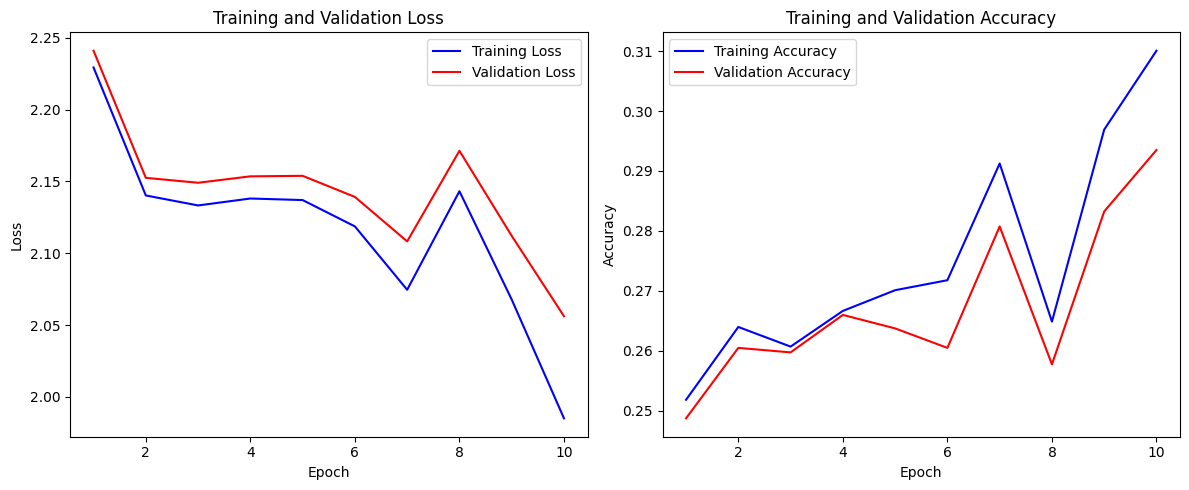

torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Si

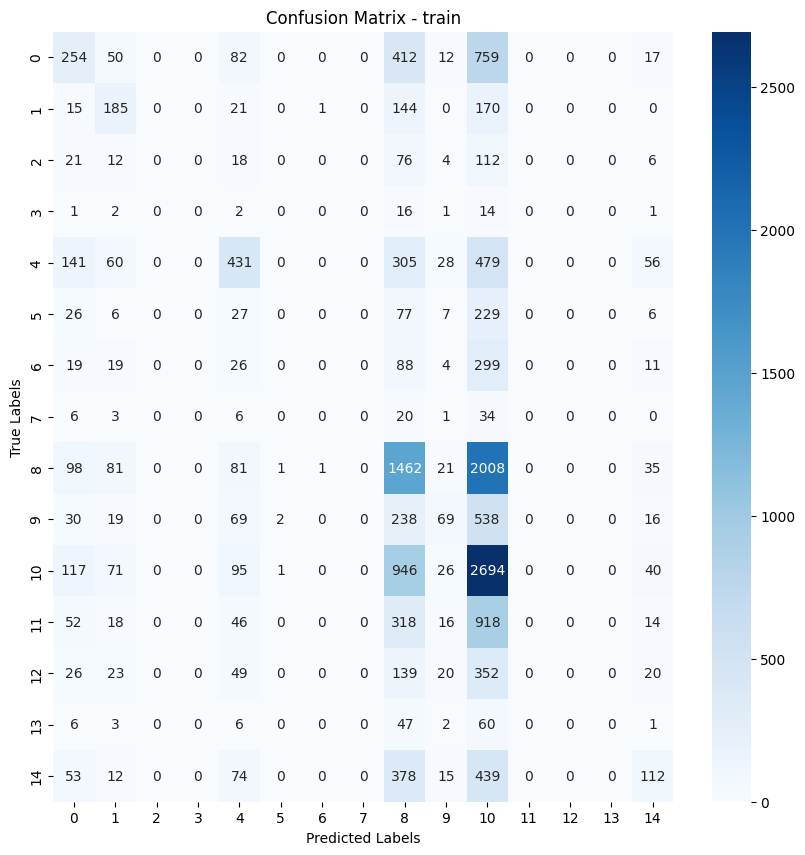

torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Si

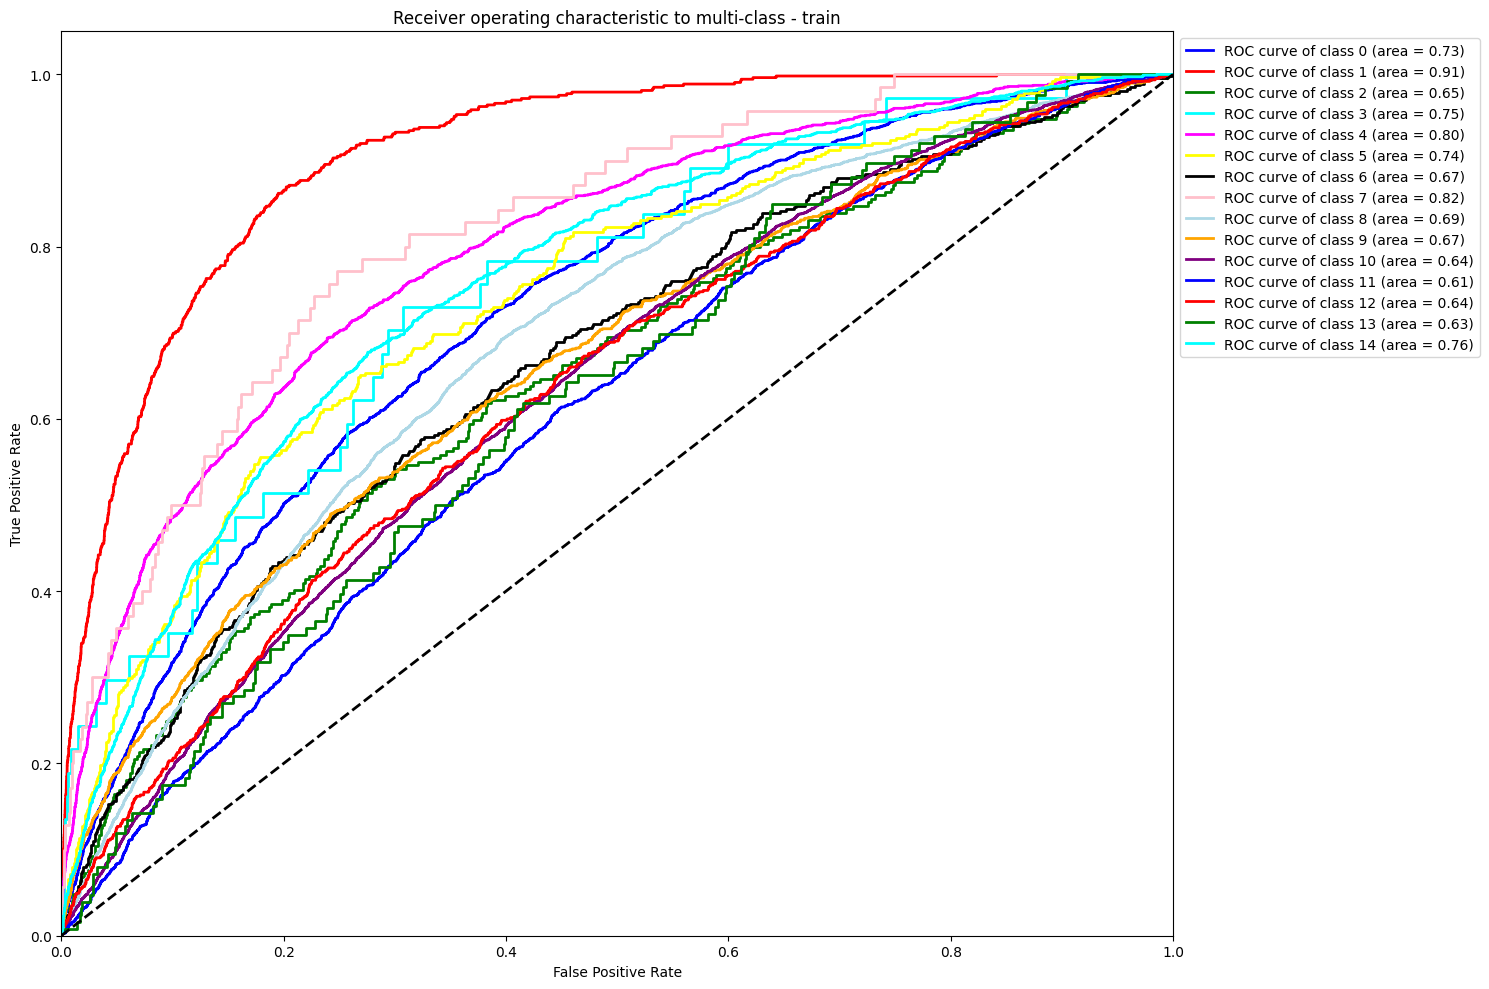

torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Si

torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])


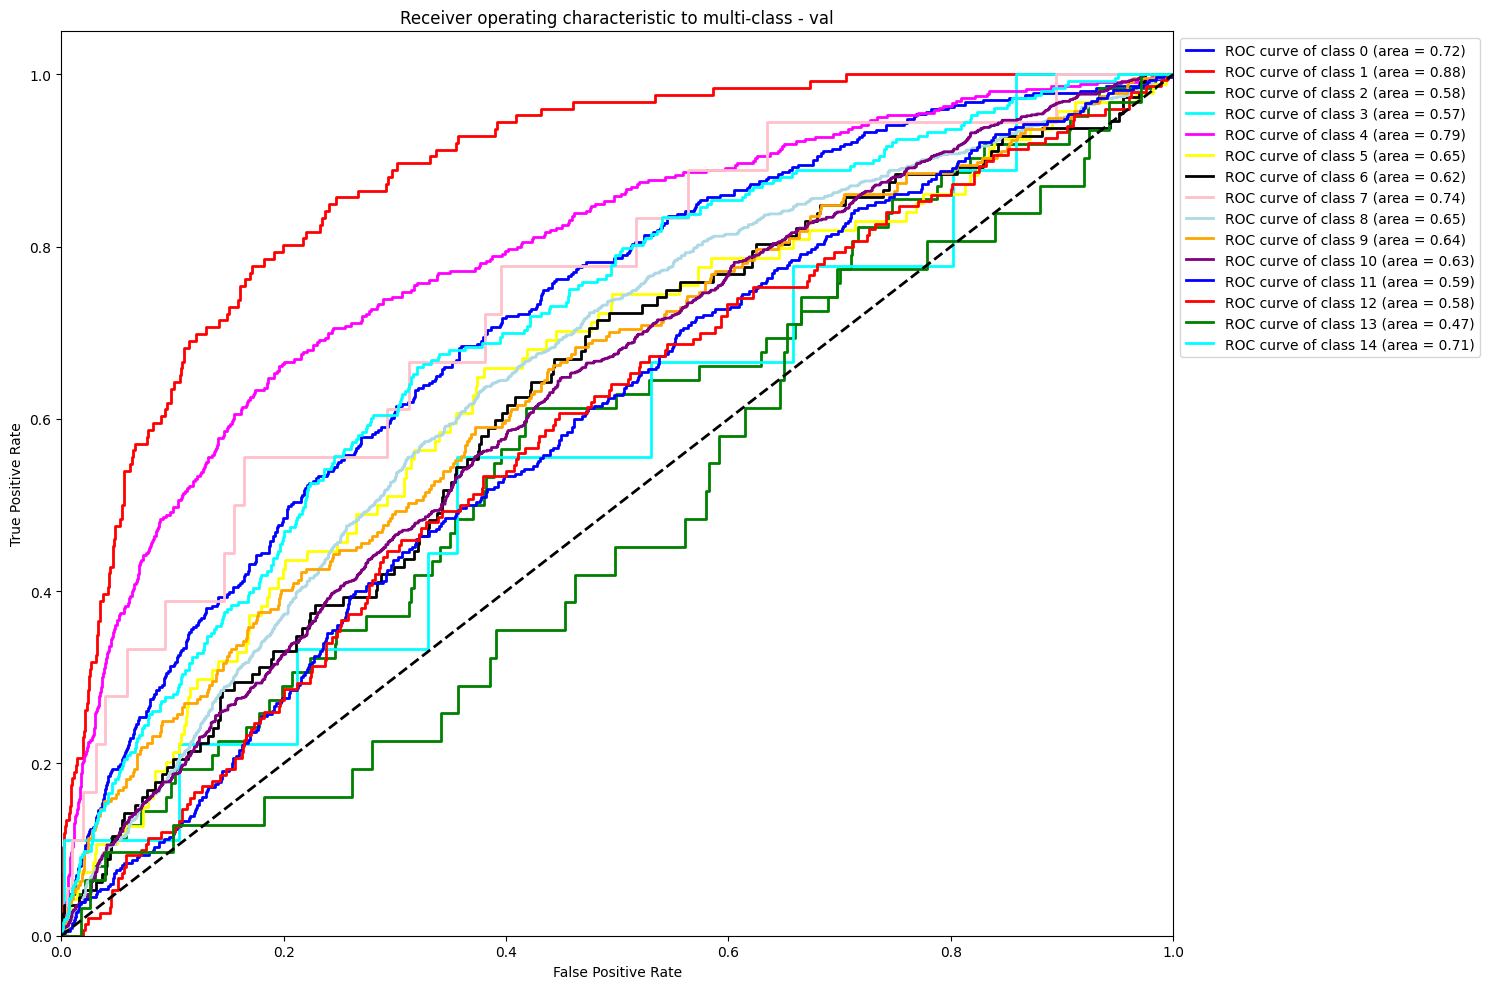

torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
torch.Size([400, 3, 100, 100])
              precision    recall  f1-score   support

           0       0.31      0.17      0.22       371
           1       0.28      0.29      0.29       126
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00         9
           4       0.41      0.31      0.35       360
           5       0.00      0.00      0.00        94
           6       1.00      0.01      0.02       112
           7       0.00      0.00      0.00        18
           8       0.28      0.35      0.31       889
           9       0.19      0.04      0.06       237
          10       0.29      0.65      0.40       958
          11       0.00      0.00      0.

In [25]:
generate_documentation(trainer, train_loader, val_loader, device, class_names)